# Custom version of Stable Diffusion

In [2]:
!pip install transformers diffusers ftfy accelerate


[notice] A new release of pip available: 22.1.2 -> 22.3.1
[notice] To update, run: pip install --upgrade pip


In [3]:
from pathlib import Path
from huggingface_hub import notebook_login
if not (Path.home()/'.huggingface'/'token').exists(): notebook_login()

In [4]:
import torch
from matplotlib import pyplot as plt
from tqdm.auto import tqdm
from PIL import Image
import math

In [5]:
from transformers import CLIPTextModel, CLIPTokenizer

In [6]:
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14", torch_dtype=torch.float16)
text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14", torch_dtype=torch.float16).to("cuda")

Some weights of the model checkpoint at openai/clip-vit-large-patch14 were not used when initializing CLIPTextModel: ['vision_model.encoder.layers.15.layer_norm2.weight', 'vision_model.encoder.layers.14.mlp.fc2.bias', 'vision_model.encoder.layers.1.self_attn.out_proj.bias', 'vision_model.encoder.layers.11.self_attn.out_proj.weight', 'vision_model.encoder.layers.22.self_attn.v_proj.bias', 'vision_model.encoder.layers.22.layer_norm1.weight', 'vision_model.encoder.layers.7.mlp.fc2.weight', 'vision_model.encoder.layers.23.self_attn.v_proj.weight', 'vision_model.encoder.layers.1.layer_norm1.bias', 'vision_model.encoder.layers.8.self_attn.out_proj.weight', 'vision_model.encoder.layers.5.layer_norm2.bias', 'vision_model.encoder.layers.12.mlp.fc1.weight', 'vision_model.encoder.layers.22.mlp.fc2.bias', 'vision_model.encoder.layers.16.self_attn.q_proj.weight', 'vision_model.pre_layrnorm.weight', 'vision_model.encoder.layers.7.self_attn.out_proj.bias', 'vision_model.encoder.layers.14.self_attn.k_

In [7]:
from diffusers import AutoencoderKL, UNet2DConditionModel

# Here we use a different VAE to the original release, which has been fine-tuned for more steps
vae = AutoencoderKL.from_pretrained("stabilityai/sd-vae-ft-ema", torch_dtype=torch.float16).to("cuda")
unet = UNet2DConditionModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="unet", torch_dtype=torch.float16).to("cuda")

In [8]:
from diffusers import LMSDiscreteScheduler
scheduler = LMSDiscreteScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", num_train_timesteps=1000)

In [10]:
!rm -rf ./imitools && git clone https://github.com/GDi4K/imitools.git
import imitools as I

Cloning into 'imitools'...
remote: Enumerating objects: 27, done.
remote: Counting objects: 100% (27/27), done.
remote: Compressing objects: 100% (21/21), done.
remote: Total 27 (delta 13), reused 11 (delta 4), pack-reused 0
Unpacking objects: 100% (27/27), 8.50 KiB | 1.06 MiB/s, done.


## From Scratch

### Making Text Embeddings for the Unet

In [11]:
prompt = ["a photograph of an astronaut riding a horse"]

In [12]:
token_info = tokenizer(prompt, padding="max_length", truncation=True, return_tensors="pt")

token_embs = text_encoder(token_info.input_ids.to("cuda"))[0];
token_embs.shape

torch.Size([1, 77, 768])

In [13]:
uncond_info = tokenizer([""] * len(prompt), padding="max_length", truncation=True, return_tensors="pt")

uncond_embs = text_encoder(uncond_info.input_ids.to("cuda"))[0]
uncond_embs.shape

torch.Size([1, 77, 768])

In [14]:
text_embs = torch.cat([uncond_embs, token_embs])
text_embs.shape

torch.Size([2, 77, 768])

### Initialize Latents & Schedular

In [15]:
height = 512
width = 512
steps = 50

In [16]:
torch.manual_seed(100)
latents = torch.randn(len(prompt), unet.in_channels, height // 8, width // 8).to("cuda").half()
latents.shape

torch.Size([1, 4, 64, 64])

In [17]:
scheduler.set_timesteps(50)

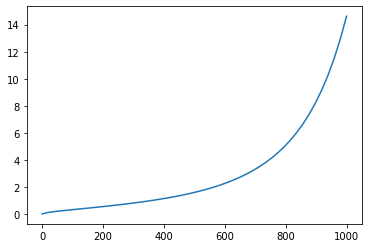

In [18]:
plt.plot(scheduler.timesteps, scheduler.sigmas[:-1])

In [19]:
latents = latents * scheduler.init_noise_sigma

### The Loop

In [20]:
guidance_scale = 7.5

In [21]:
for i, t in enumerate(tqdm(scheduler.timesteps)):
    input = torch.cat([latents] * 2)
    input = scheduler.scale_model_input(input, t)

    # predict the noise residual
    with torch.no_grad(): pred = unet(input, t, encoder_hidden_states=text_embs).sample

    # perform guidance
    pred_uncond, pred_text = pred.chunk(2)
    pred = pred_uncond + guidance_scale * (pred_text - pred_uncond)

    # compute the "previous" noisy sample
    updated_info = scheduler.step(pred, t, latents)
    latents = updated_info.prev_sample

  0%|          | 0/50 [00:00<?, ?it/s]

### Latent to the Image

In [65]:
with torch.no_grad():
    im_data = vae.decode(latents * 1 / 0.18215).sample[0]

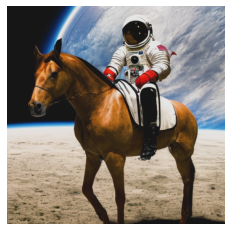

In [68]:
I.wrap(im_data).normalize().show()

## Methods

In [30]:
prompt = ["a photograph of an astronaut riding a horse"]

In [31]:
def make_token_embs(promt): 
    token_info = tokenizer(prompt, padding="max_length", truncation=True, return_tensors="pt")
    token_embs = text_encoder(token_info.input_ids.to("cuda"))[0];
    return token_embs

In [32]:
def gen_image(token_embs, height=512, width=512, steps=50, gd=7.5, seed=100, get_all=False, return_preview=False):
    # make text_embs
    uncond_info = tokenizer([""] * len(token_embs), padding="max_length", truncation=True, return_tensors="pt")
    uncond_embs = text_encoder(uncond_info.input_ids.to("cuda"))[0]
    text_embs = torch.cat([uncond_embs, token_embs])

    torch.manual_seed(seed)
    latents = torch.randn(len(token_embs), unet.in_channels, height // 8, width // 8).to("cuda").half()
    latents.shape

    scheduler.set_timesteps(steps)

    latents = latents * scheduler.init_noise_sigma
    latents_list = []
    
    for i, t in enumerate(tqdm(scheduler.timesteps)):
        input = torch.cat([latents] * 2)
        input = scheduler.scale_model_input(input, t)

        # predict the noise residual
        with torch.no_grad(): pred = unet(input, t, encoder_hidden_states=text_embs).sample

        # perform guidance
        pred_uncond, pred_text = pred.chunk(2)
        pred = pred_uncond + guidance_scale * (pred_text - pred_uncond)

        # compute the "previous" noisy sample
        updated_info = scheduler.step(pred, t, latents)
        latents = updated_info.prev_sample
        
        if get_all:
            latents_list.append(updated_info.pred_original_sample if return_preview else latents)
    
    if get_all:
        return latents_list
    
    return latents

In [51]:
def decode_latents(latents, scale_factor=1.0):
    with torch.no_grad():
        im_data = vae.decode(latents * 1 / 0.18215).sample[0]
    
    _, width, height = im_data.shape
    
    return I.wrap(im_data * 0.5 + 0.5).cpil().resize((width * scale_factor, height * scale_factor)).pil()

In [62]:
def show_latents_grid(latents_list, cols=8, scale_factor=2.5):
    images = [decode_latents(item) for item in latents_list]
    I.wrap(images).show(cols=cols, scale=scale_factor, max_count=len(images))

### Usage

  0%|          | 0/50 [00:00<?, ?it/s]

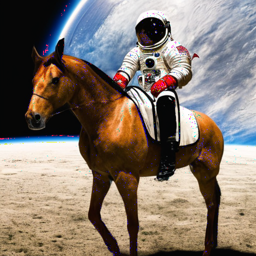

In [54]:
prompt = ["a photograph of an astronaut riding a horse"]
latents = gen_image(make_token_embs(prompt))
decode_latents(latents, scale_factor=0.5)

  0%|          | 0/20 [00:00<?, ?it/s]

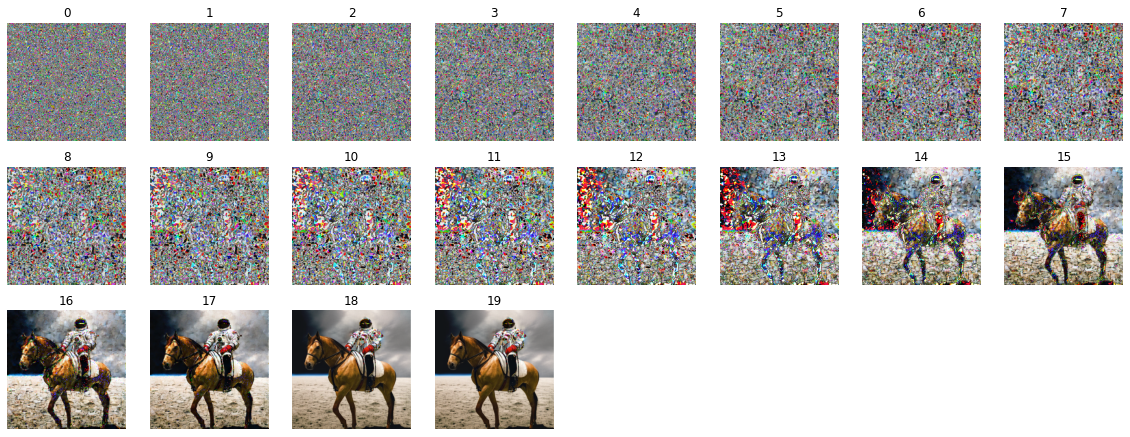

In [53]:
prompt = ["a photograph of an astronaut riding a horse"]
latents_list = gen_image(make_token_embs(prompt), steps=20, get_all=True)
show_latents_grid(latents_list)

  0%|          | 0/50 [00:00<?, ?it/s]

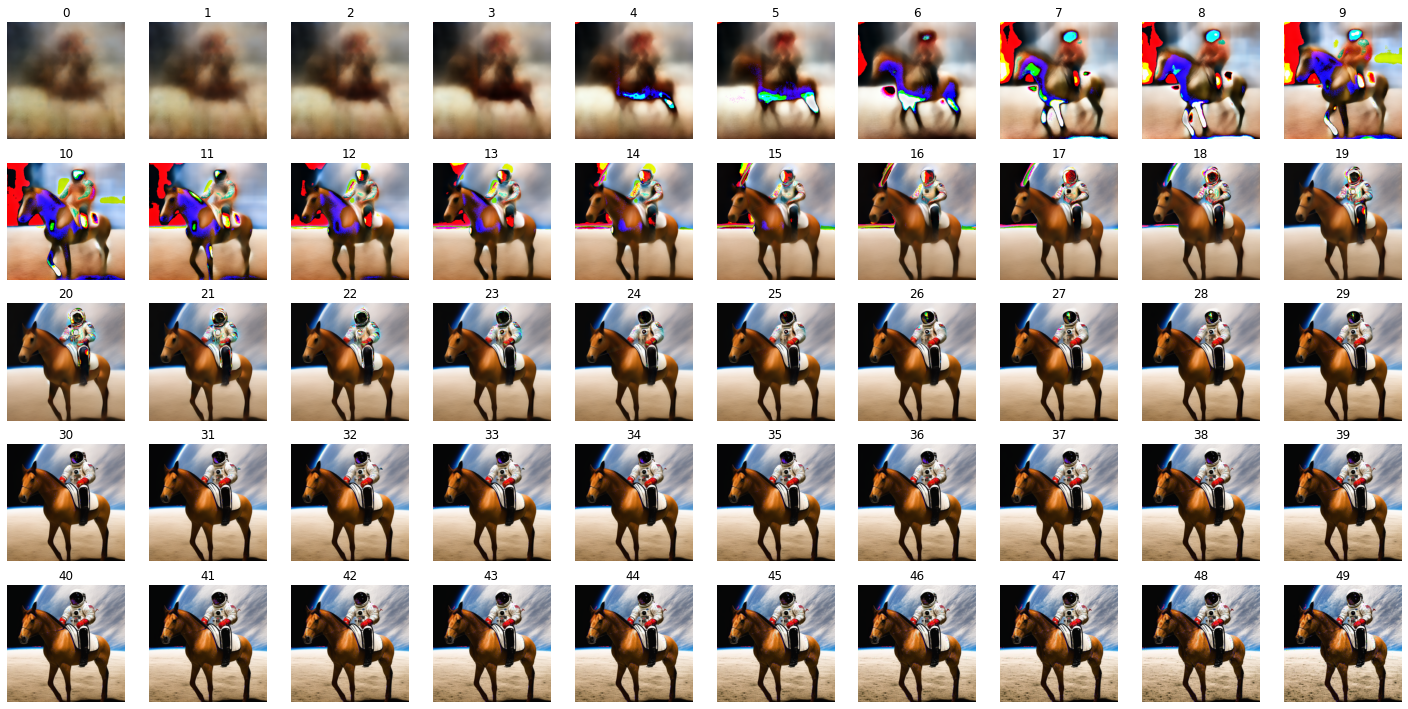

In [63]:
prompt = ["a photograph of an astronaut riding a horse"]
latents_list = gen_image(make_token_embs(prompt), steps=50, get_all=True, return_preview=True)
show_latents_grid(latents_list, cols=10)

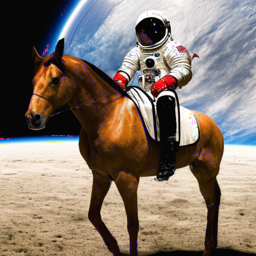

In [60]:
decode_latents(latents_list[-2], scale_factor=0.5)